<a href="https://colab.research.google.com/github/ancestor9/Affalatoxin-Analysis/blob/main/prediction/0910_%EC%95%84%ED%94%8C%EB%9D%BC%ED%86%A1%EC%8B%A0_CNN_LSTM_%EC%A1%B0%EC%83%81%EA%B5%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 사용된 기상항목
- tmprt_150	기온(150CM)
- tmprt_150Top	기온(150CM)최고
- tmprt_150Lwet	기온(150CM)최저
- hd_150	습도(150CM)
- arvlty_300	풍속(300CM)
- arvlty_300Top	최대풍속(300CM)
- afp	강수량
- sunshn_Time	일조시간
- solrad_Qy	일사량
- soil_Mitr_10	토양수분(10CM)

### 데이터 생성 방법
- 통합_LIMS에서 각 건에 대해 주소에 의해 (위도, 경도) 정보 api에서 조회
- 해당 주소가 없으면 상세 -> 넓은 범위로 넓혀가면서 조회
- 해당 (위도, 경도)와 가장 가까운 관측소를 찾아 해당일 기준 과거 30일 상기 기상항목을 record 형태로 만듦
- 혹시 필요할지 몰라 X에 이런 항목도 추가했음
    - INSPCT_PURPS_NAME
    - INSPCT_KND_NAME
    - PRDLST_NM
    - SPLORE_STTUS_NAME
    - ORGPLCE_NATION_CODE

### 데이터 읽는 방법
df_통합_LIMS_기상정보_결합_y = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_y.pkl', compression='gzip')
df_통합_LIMS_기상정보_결합_X = pd.read_pickle('../results/df_통합_LIMS_기상정보_결합_gzip_X.pkl', compression='gzip')

In [ ]:
# !pip install tensorflow -q

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1. 데이터 수집 및 전처리**
### 상기실험확임함은 제거
### 가공식품 데이터만 분석대상으로

In [2]:
import pandas as pd
import numpy as np
# import tensorflow as tf
# from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
# from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# --- 1단계: 데이터 로드 ---

data= pd.read_pickle('/content/drive/MyDrive/식약처/merged_df_no_original_target_pickle.pkl')
data.shape

(130341, 273)

### 작업 1. 검사종류와 식품종류의 경우에 부적합율을 생성
#### - 부적합률이 0 인 검사종류와 식품종류는 제거
#### - 즉 여기에 해당되는 식품은 아폴라톡신이 나온 경우가 과거에 없으니 예측도 무조건 없다고 한다.

In [3]:
grouped_data = data.groupby(['INSPCT_PURPS_NAME', 'PRDLST_NM'])['JDGMNT_WORD_NAME_encoded'].mean().reset_index()
filtered_data = grouped_data[grouped_data['JDGMNT_WORD_NAME_encoded'] == 0]
# Create a boolean mask for rows to keep
rows_to_keep = ~data.set_index(['INSPCT_PURPS_NAME', 'PRDLST_NM']).index.isin(filtered_data.set_index(['INSPCT_PURPS_NAME', 'PRDLST_NM']).index)
# Filter the original data DataFrame
data_filtered_removed = data[rows_to_keep].copy()
data_filtered_removed.shape

(113491, 273)

In [4]:
## Target Mean
# Merge data_filtered_removed with grouped_data
data_filtered_removed = data_filtered_removed.merge(
    grouped_data[['INSPCT_PURPS_NAME', 'PRDLST_NM', 'JDGMNT_WORD_NAME_encoded']],
    on=['INSPCT_PURPS_NAME', 'PRDLST_NM'],
    how='left',
    suffixes=('', '_mean_encoded') # Add a suffix to the merged column name
)

# Rename the merged column to avoid conflict with existing column if any
data_filtered_removed.rename(columns={'JDGMNT_WORD_NAME_encoded_mean_encoded': 'JDGMNT_WORD_NAME_encoded_mean'}, inplace=True)
data_filtered_removed.shape

(113491, 274)

In [5]:
data_filtered_removed = data_filtered_removed.drop(columns=['INSPCT_PURPS_NAME', 'PRDLST_NM', 'JDGMNT_WORD_NAME_encoded_mean'])
display(data_filtered_removed.head())

,afp_00,afp_01,afp_02,afp_03,afp_04,afp_05,afp_06,afp_07,afp_08,afp_09,...,tmprt_150_21,tmprt_150_22,tmprt_150_23,tmprt_150_24,tmprt_150_25,tmprt_150_26,tmprt_150_27,tmprt_150_28,tmprt_150_29,JDGMNT_WORD_NAME_encoded
0,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4,0
1,1.0,1.0,0.0,0.5,0.5,0.0,0.5,0.0,0.0,0.0,...,-1.1,0.8,0.2,2.0,-2.8,-4.6,-3.4,0.2,-5.4,0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6,0
3,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.8,3.0,1.7,6.0,0.1,-2.9,-2.0,3.1,-2.6,0
4,0.0,0.5,0.0,0.5,0.0,0.0,0.5,0.0,0.0,0.0,...,1.4,3.4,2.1,4.1,0.0,-2.4,-1.8,3.3,-1.8,0


In [6]:
X = data_filtered_removed.drop(columns=['JDGMNT_WORD_NAME_encoded'])
y = data_filtered_removed['JDGMNT_WORD_NAME_encoded']

In [7]:
y.value_counts(normalize=True)*100

,proportion
JDGMNT_WORD_NAME_encoded,
0,99.504807
1,0.495193


# **2. 예측모형 개발**
- goal 1 : Positive를 찾아내는 것을 최대 목표로 하는 함수를 설정
- goal 2 : f1-score를 최대화하는 의사결정임계값(Threshhold)을 찾기(default =0.5)
- epoch은 2번만 아래 3개 모델을 비교
- scikit-learn의 XGBoost 모델도 같은 목적(goal 1, goal 2)을 설정하여 진행하면 비슷한 결과가 나올 듯


### 2.1. LSTM + Attention 모델 (가장 추천)
- 시계열의 장기 의존성을 LSTM으로 포착
- Attention으로 중요한 시점에 집중
- 불균형 데이터에 효과적

### 2.2. 1D CNN + LSTM 결합
- CNN으로 국소적 패턴 추출
- LSTM으로 시간적 의존성 학습
- 계산 효율성 우수

### 2.3. 불균형 데이터 특화 기법들:
- Focal Loss: 어려운 샘플에 더 집중
- Class Weights: Positive 클래스에 높은 가중치
- Early Stopping: 과적합 방지

원본 데이터 형태: X=(113491, 270), y=(113491,)
원본 클래스 분포: Counter({np.int64(0): 112929, np.int64(1): 562})

SMOTE 적용 중...
SMOTE 후 데이터 형태: X=(225858, 270), y=(225858,)
SMOTE 후 클래스 분포: Counter({np.int64(0): 112929, np.int64(1): 112929})

데이터 전처리 중...
Input X shape: (158100, 270)
Reshaped X: (158100, 30, 9)
Scaler fitted on training data
Input X shape: (33879, 270)
Reshaped X: (33879, 30, 9)
Class distribution: Counter({np.int64(0): 79050, np.int64(1): 79050})

Training LSTM_Attention Model
사용된 positive weight: 1.00
Starting training for LSTM_Attention...
Training data shape: (158100, 30, 9)
Validation data shape: (33879, 30, 9)
Epoch 1/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 1049s 200ms/step - accuracy: 0.5127 - loss: 0.6984 - precision: 0.5579 - recall: 0.1276 - val_accuracy: 0.4999 - val_loss: 0.6869 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 1037s 200ms/step - accuracy: 0.5100 - loss: 0.6902 - precision: 0.6159 - recall: 0.0

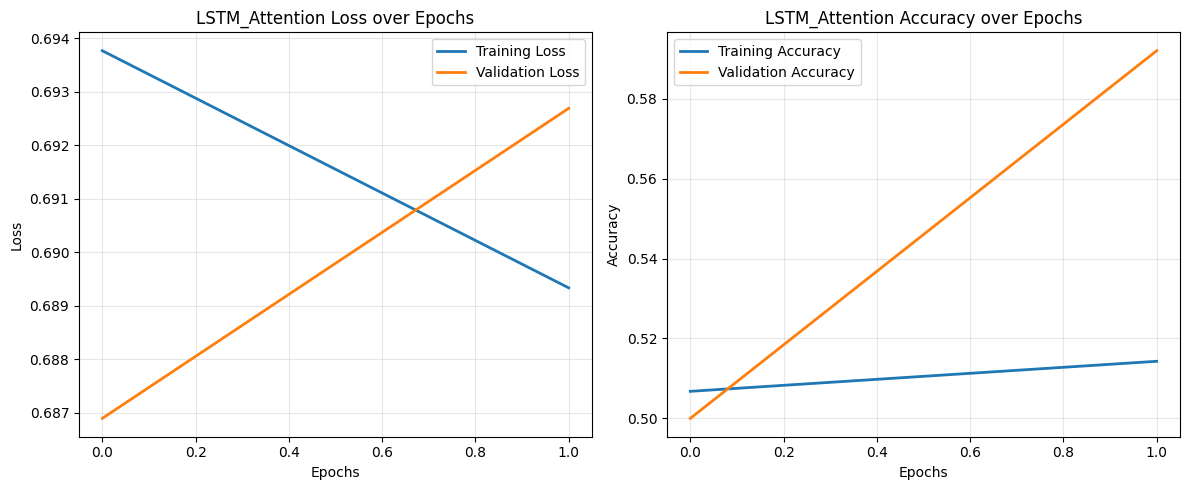


=== LSTM_Attention 결과 ===
최적 임계값: 0.0012 (F1-score: 0.6822)
AUC Score: 0.5969

--- 최적 임계값 (0.0012) 결과 ---
              precision    recall  f1-score   support

           0       0.74      0.13      0.22     16939
           1       0.52      0.95      0.68     16940

    accuracy                           0.54     33879
   macro avg       0.63      0.54      0.45     33879
weighted avg       0.63      0.54      0.45     33879



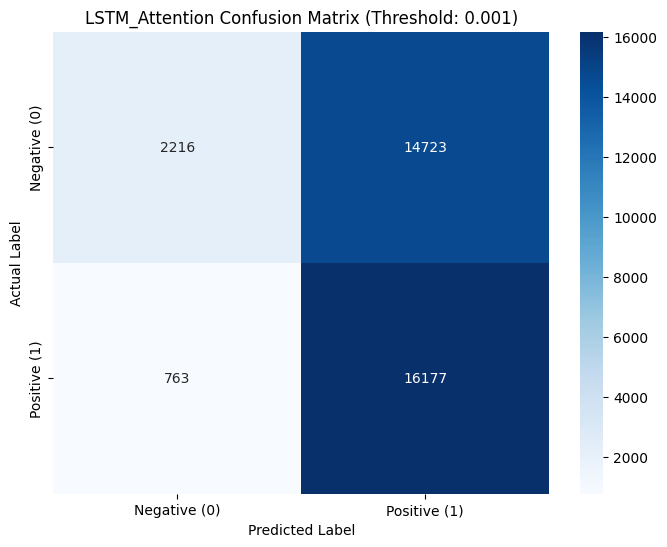


Training CNN_LSTM Model
사용된 positive weight: 1.00
Starting training for CNN_LSTM...
Training data shape: (158100, 30, 9)
Validation data shape: (33879, 30, 9)
Epoch 1/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 78s 15ms/step - accuracy: 0.5700 - loss: 0.6837 - precision: 0.6456 - recall: 0.3244 - val_accuracy: 0.6706 - val_loss: 0.6442 - val_precision: 0.7769 - val_recall: 0.4786 - learning_rate: 0.0010
Epoch 2/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 72s 15ms/step - accuracy: 0.6358 - loss: 0.6581 - precision: 0.7354 - recall: 0.4204 - val_accuracy: 0.6792 - val_loss: 0.6378 - val_precision: 0.7898 - val_recall: 0.4884 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 2.


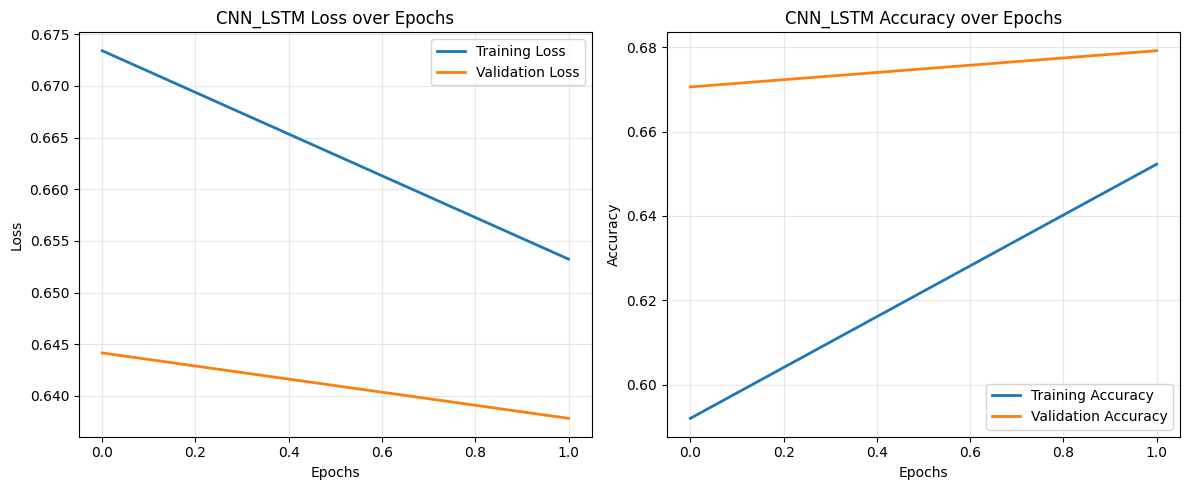


=== CNN_LSTM 결과 ===
최적 임계값: 0.0001 (F1-score: 0.6914)
AUC Score: 0.7340

--- 최적 임계값 (0.0001) 결과 ---
              precision    recall  f1-score   support

           0       0.70      0.50      0.58     16939
           1       0.61      0.78      0.69     16940

    accuracy                           0.64     33879
   macro avg       0.65      0.64      0.63     33879
weighted avg       0.65      0.64      0.63     33879



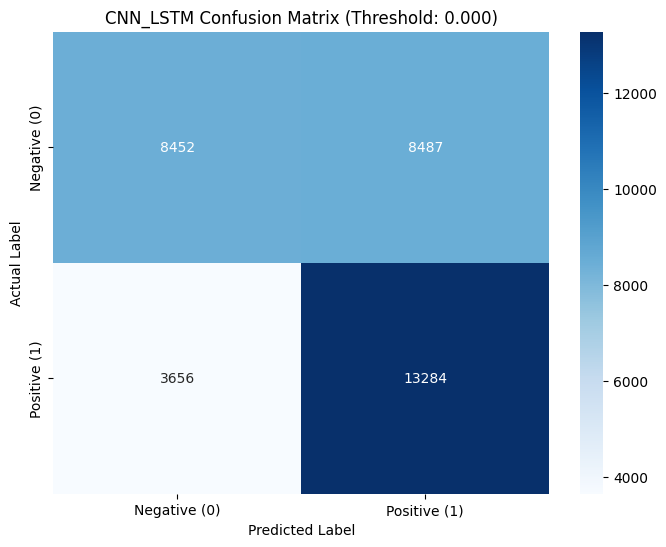


Training Transformer Model
사용된 positive weight: 1.00
Starting training for Transformer...
Training data shape: (158100, 30, 9)
Validation data shape: (33879, 30, 9)
Epoch 1/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 48s 7ms/step - accuracy: 0.5001 - loss: 0.6937 - precision: 0.5666 - recall: 0.0129 - val_accuracy: 0.4998 - val_loss: 0.6906 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 28s 6ms/step - accuracy: 0.5145 - loss: 0.6903 - precision: 0.6788 - recall: 0.0529 - val_accuracy: 0.5000 - val_loss: 0.6931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


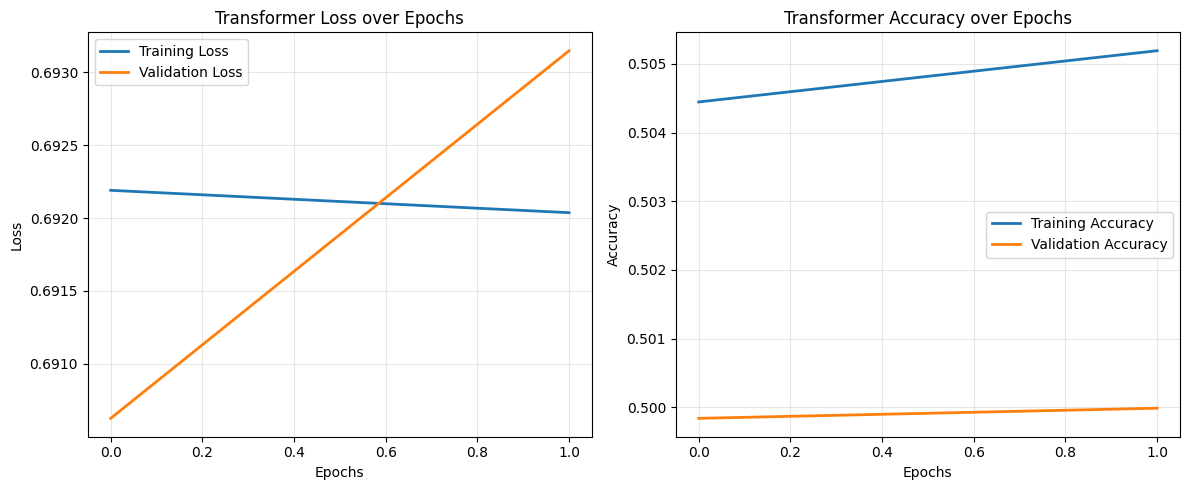


=== Transformer 결과 ===
최적 임계값: 0.0001 (F1-score: 0.6714)
AUC Score: 0.5951

--- 최적 임계값 (0.0001) 결과 ---
              precision    recall  f1-score   support

           0       0.76      0.06      0.11     16939
           1       0.51      0.98      0.67     16940

    accuracy                           0.52     33879
   macro avg       0.63      0.52      0.39     33879
weighted avg       0.63      0.52      0.39     33879



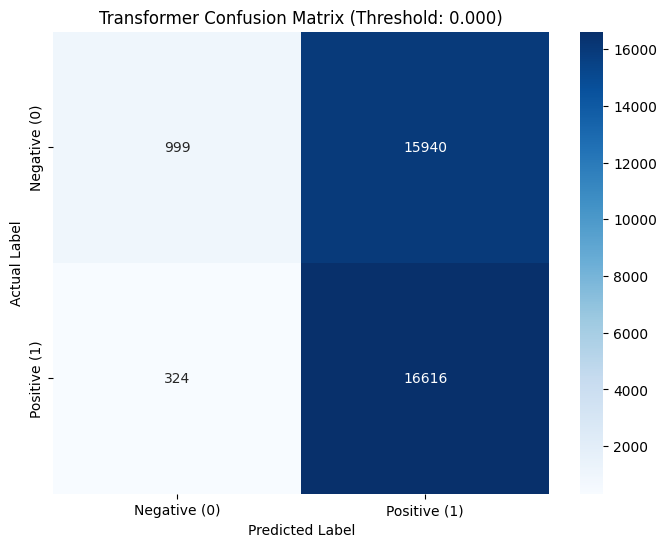


Training Ensemble Model
사용된 positive weight: 1.00
Starting training for Ensemble...
Training data shape: (158100, 30, 9)
Validation data shape: (33879, 30, 9)
Epoch 1/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 73s 14ms/step - accuracy: 0.6402 - loss: 0.6609 - precision: 0.7112 - recall: 0.4717 - val_accuracy: 0.5018 - val_loss: 0.6908 - val_precision: 0.9054 - val_recall: 0.0040 - learning_rate: 0.0010
Epoch 2/2
4941/4941 ━━━━━━━━━━━━━━━━━━━━ 82s 14ms/step - accuracy: 0.7251 - loss: 0.6275 - precision: 0.7820 - recall: 0.6277 - val_accuracy: 0.5564 - val_loss: 0.7718 - val_precision: 0.5314 - val_recall: 0.9547 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 1.


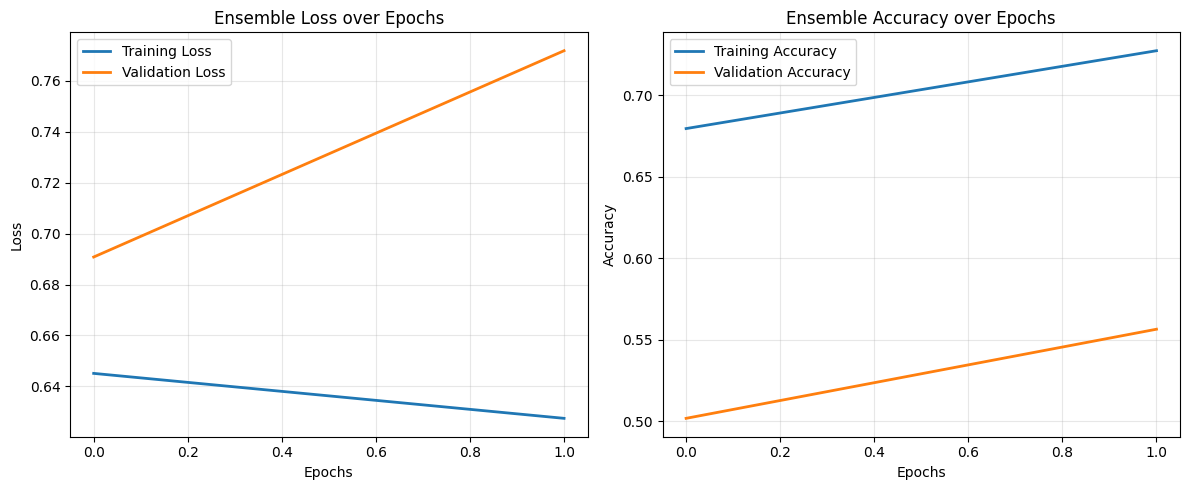


=== Ensemble 결과 ===
최적 임계값: 0.0000 (F1-score: 0.7323)
AUC Score: 0.7600

--- 최적 임계값 (0.0000) 결과 ---
              precision    recall  f1-score   support

           0       0.73      0.77      0.75     16939
           1       0.75      0.71      0.73     16940

    accuracy                           0.74     33879
   macro avg       0.74      0.74      0.74     33879
weighted avg       0.74      0.74      0.74     33879



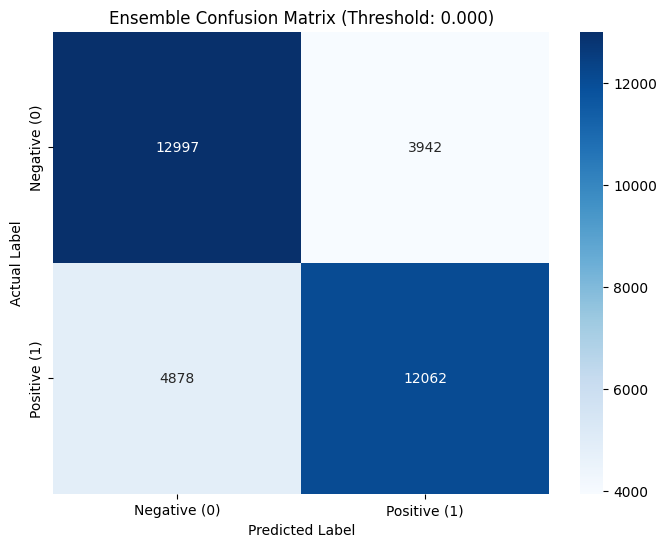


모든 모델 훈련 완료!


In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve
from collections import Counter
import matplotlib.pyplot as plt
import os
import seaborn as sns
from imblearn.over_sampling import SMOTE

# GPU 메모리 증가 설정
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Custom Transformer Block Layer 클래스 정의 (최상위 레벨로 이동)
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
        })
        return config

class ImbalancedTimeSeriesModels:
    def __init__(self, sequence_length=30, n_features=7):
        self.sequence_length = sequence_length
        self.n_features = n_features
        self.scaler = StandardScaler()
        self.is_fitted = False

    def prepare_data(self, X, y, is_train=True):
        """데이터 전처리 및 reshape"""
        print(f"Input X shape: {X.shape}")

        # 특성 수 자동 계산
        if self.n_features is None or X.shape[1] % self.sequence_length != 0:
            self.n_features = X.shape[1] // self.sequence_length
            print(f"Calculated n_features: {self.n_features}")

        # 시계열 데이터 reshape: (samples, timesteps, features)
        try:
            X_reshaped = X.reshape(-1, self.sequence_length, self.n_features)
            print(f"Reshaped X: {X_reshaped.shape}")
        except ValueError as e:
            print(f"Reshape error: {e}")
            # 데이터 크기 조정
            total_features_needed = self.sequence_length * self.n_features
            if X.shape[1] > total_features_needed:
                X = X[:, :total_features_needed]
            elif X.shape[1] < total_features_needed:
                # 부족한 특성은 0으로 패딩
                padding_needed = total_features_needed - X.shape[1]
                padding = np.zeros((X.shape[0], padding_needed))
                X = np.concatenate([X, padding], axis=1)

            X_reshaped = X.reshape(-1, self.sequence_length, self.n_features)
            print(f"Adjusted and reshaped X: {X_reshaped.shape}")

        # 정규화
        if is_train and not self.is_fitted:
            # 훈련 데이터로 스케일러 학습
            X_2d = X_reshaped.reshape(-1, self.n_features)
            self.scaler.fit(X_2d)
            self.is_fitted = True
            print("Scaler fitted on training data")

        # 스케일링 적용
        X_2d = X_reshaped.reshape(-1, self.n_features)
        X_scaled_2d = self.scaler.transform(X_2d)
        X_scaled = X_scaled_2d.reshape(-1, self.sequence_length, self.n_features)

        return X_scaled, y

    def calculate_class_weights(self, y):
        """클래스 가중치 계산"""
        counter = Counter(y)
        total = sum(counter.values())
        class_weights = {}

        for class_label in [0, 1]:  # 명시적으로 0, 1 클래스 처리
            if class_label in counter:
                class_weights[class_label] = total / (2 * counter[class_label])
            else:
                class_weights[class_label] = 1.0  # 기본값

        print(f"Class distribution: {counter}")
        return class_weights

    def focal_loss(self, alpha=0.25, gamma=2.0):
        """Focal Loss 함수 - 불균형 데이터에 효과적"""
        def focal_loss_fixed(y_true, y_pred):
            epsilon = tf.keras.backend.epsilon()
            y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)

            # y_true를 float32로 캐스팅
            y_true = tf.cast(y_true, tf.float32)

            alpha_t = y_true * alpha + (1 - y_true) * (1 - alpha)
            p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
            focal_loss = -alpha_t * tf.pow((1 - p_t), gamma) * tf.math.log(p_t)

            return tf.reduce_mean(focal_loss)
        return focal_loss_fixed

    def weighted_binary_crossentropy(self, pos_weight):
        """가중 이진 크로스 엔트로피 손실 함수"""
        def loss_func(y_true, y_pred):
            return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight)
        return loss_func

    def build_lstm_attention_model(self):
        """LSTM + Attention 모델"""
        inputs = layers.Input(shape=(self.sequence_length, self.n_features))

        # LSTM layers with dropout
        lstm1 = layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(inputs)
        lstm2 = layers.LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(lstm1)

        # Attention mechanism
        attention = layers.MultiHeadAttention(num_heads=4, key_dim=64)(lstm2, lstm2)
        attention = layers.Dropout(0.2)(attention)

        # Global pooling
        pooling = layers.GlobalAveragePooling1D()(attention)

        # Dense layers
        dense1 = layers.Dense(64, activation='relu')(pooling)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        dense2 = layers.Dense(32, activation='relu')(dense1)
        dense2 = layers.BatchNormalization()(dense2)
        dense2 = layers.Dropout(0.3)(dense2)

        # Output layer with sigmoid for binary classification
        outputs = layers.Dense(1, activation='sigmoid')(dense2)

        model = keras.Model(inputs, outputs)
        return model

    def build_1dcnn_lstm_model(self):
        """1D CNN + LSTM 모델"""
        inputs = layers.Input(shape=(self.sequence_length, self.n_features))

        # 1D CNN layers
        conv1 = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.Dropout(0.2)(conv1)

        conv2 = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(conv1)
        conv2 = layers.BatchNormalization()(conv2)
        conv2 = layers.Dropout(0.2)(conv2)

        # LSTM layers
        lstm1 = layers.LSTM(64, return_sequences=True, dropout=0.2)(conv2)
        lstm2 = layers.LSTM(32, dropout=0.2)(lstm1)

        # Dense layers
        dense1 = layers.Dense(32, activation='relu')(lstm2)
        dense1 = layers.BatchNormalization()(dense1)
        dense1 = layers.Dropout(0.3)(dense1)

        outputs = layers.Dense(1, activation='sigmoid')(dense1)

        model = keras.Model(inputs, outputs)
        return model

    def build_transformer_model(self):
        """Transformer 기반 모델"""
        inputs = layers.Input(shape=(self.sequence_length, self.n_features))

        # Positional encoding
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        position_embedding = layers.Embedding(
            input_dim=self.sequence_length,
            output_dim=self.n_features
        )
        pos_encoding = position_embedding(positions)

        # Broadcasting을 위한 차원 확장
        pos_encoding = tf.expand_dims(pos_encoding, axis=0)
        x = inputs + pos_encoding

        # Transformer blocks
        transformer_block1 = TransformerBlock(
            embed_dim=self.n_features,
            num_heads=min(4, self.n_features),
            ff_dim=64,
            rate=0.2
        )
        x = transformer_block1(x)

        transformer_block2 = TransformerBlock(
            embed_dim=self.n_features,
            num_heads=min(4, self.n_features),
            ff_dim=64,
            rate=0.2
        )
        x = transformer_block2(x)

        # Global pooling and classification
        pooling = layers.GlobalAveragePooling1D()(x)
        dense = layers.Dense(32, activation='relu')(pooling)
        dense = layers.Dropout(0.3)(dense)
        outputs = layers.Dense(1, activation='sigmoid')(dense)

        model = keras.Model(inputs, outputs)
        return model

    def build_ensemble_model(self):
        """앙상블 모델"""
        inputs = layers.Input(shape=(self.sequence_length, self.n_features))

        # LSTM branch
        lstm_branch = layers.LSTM(64, return_sequences=False, dropout=0.2)(inputs)
        lstm_branch = layers.Dense(32, activation='relu')(lstm_branch)

        # CNN branch
        cnn_branch = layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(inputs)
        cnn_branch = layers.GlobalMaxPooling1D()(cnn_branch)
        cnn_branch = layers.Dense(32, activation='relu')(cnn_branch)

        # Attention branch
        attn_branch = layers.MultiHeadAttention(num_heads=min(4, self.n_features), key_dim=32)(inputs, inputs)
        attn_branch = layers.GlobalAveragePooling1D()(attn_branch)
        attn_branch = layers.Dense(32, activation='relu')(attn_branch)

        # Concatenate all branches
        concatenated = layers.concatenate([lstm_branch, cnn_branch, attn_branch])

        # Final layers
        dense = layers.Dense(64, activation='relu')(concatenated)
        dense = layers.BatchNormalization()(dense)
        dense = layers.Dropout(0.3)(dense)

        outputs = layers.Dense(1, activation='sigmoid')(dense)

        model = keras.Model(inputs, outputs)
        return model

def find_optimal_threshold(y_true, y_pred_proba):
    """최적 임계값 찾기"""
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred_proba)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    return optimal_threshold, f1_scores[optimal_idx]

def plot_history(history, model_name):
    """훈련 과정 시각화"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_title(f'{model_name} Loss over Epochs')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    axes[1].set_title(f'{model_name} Accuracy over Epochs')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name, threshold):
    """Confusion Matrix 시각화"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative (0)', 'Positive (1)'],
                yticklabels=['Negative (0)', 'Positive (1)'])
    plt.title(f'{model_name} Confusion Matrix (Threshold: {threshold:.3f})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

def train_and_evaluate(model, X_train, y_train, X_val, y_val, class_weights, model_name="Model"):
    """모델 훈련 및 평가"""

    # 모델 컴파일 - 손실 함수 선택
    model_trainer = ImbalancedTimeSeriesModels()

    # 극불균형 데이터를 위한 손실 함수 선택
    pos_weight = class_weights[1] / class_weights[0] if class_weights[1] > 0 else 10.0

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=model_trainer.weighted_binary_crossentropy(pos_weight=pos_weight),
        metrics=['accuracy', 'precision', 'recall']
    )

    print(f"사용된 positive weight: {pos_weight:.2f}")

    # 콜백 설정
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=4,
            min_lr=1e-6,
            verbose=1
        )
    ]

    print(f"Starting training for {model_name}...")
    print(f"Training data shape: {X_train.shape}")
    print(f"Validation data shape: {X_val.shape}")

    try:
        history = model.fit(
            X_train, y_train,
            batch_size=32,
            epochs=2,
            validation_data=(X_val, y_val),
            class_weight=class_weights,
            callbacks=callbacks,
            verbose=1
        )

        # 훈련 과정 시각화
        plot_history(history, model_name)

        # 예측 및 평가
        y_pred_proba = model.predict(X_val, verbose=0)

        optimal_threshold, best_f1 = find_optimal_threshold(y_val, y_pred_proba.ravel())
        y_pred_optimal = (y_pred_proba > optimal_threshold).astype(int)

        print(f"\n=== {model_name} 결과 ===")
        print(f"최적 임계값: {optimal_threshold:.4f} (F1-score: {best_f1:.4f})")

        # AUC 계산 (예외 처리 추가)
        try:
            auc_score = roc_auc_score(y_val, y_pred_proba)
            print(f"AUC Score: {auc_score:.4f}")
        except ValueError as e:
            print(f"AUC Score 계산 불가: {e}")

        print(f"\n--- 최적 임계값 ({optimal_threshold:.4f}) 결과 ---")
        print(classification_report(y_val, y_pred_optimal))

        # Confusion Matrix 시각화
        plot_confusion_matrix(y_val, y_pred_optimal, model_name, optimal_threshold)

        return model, history, y_pred_proba, optimal_threshold

    except Exception as e:
        print(f"Training failed for {model_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

def main():
    """메인 실행 함수"""

    try:
        # 전역 변수에서 데이터 가져오기
        global X, y
        if isinstance(X, pd.DataFrame):
            X_np = X.values
        else:
            X_np = X.copy()
        if isinstance(y, pd.Series):
            y_np = y.values
        else:
            y_np = y.copy()
    except NameError:
        print("전역 변수 X, y를 찾을 수 없습니다. 예제 데이터를 생성합니다...")
        np.random.seed(42)
        n_samples = 1000
        sequence_length = 30
        n_features = 7
        X_np = np.random.randn(n_samples, sequence_length * n_features)
        y_np = np.zeros(n_samples)
        # 극불균형 데이터 생성 (0.5%)
        positive_indices = np.random.choice(n_samples, size=int(n_samples * 0.005), replace=False)
        y_np[positive_indices] = 1

    print(f"원본 데이터 형태: X={X_np.shape}, y={y_np.shape}")
    print(f"원본 클래스 분포: {Counter(y_np)}")

    # SMOTE 적용 (극불균형 데이터 처리)
    print("\nSMOTE 적용 중...")
    sm = SMOTE(random_state=42, k_neighbors=1)  # k_neighbors=1로 설정 (극소수 클래스 대응)
    X_resampled, y_resampled = sm.fit_resample(X_np, y_np)

    print(f"SMOTE 후 데이터 형태: X={X_resampled.shape}, y={y_resampled.shape}")
    print(f"SMOTE 후 클래스 분포: {Counter(y_resampled)}")

    # 파라미터 설정
    sequence_length = 30
    n_features = X_np.shape[1] // sequence_length

    # 데이터 분할
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_resampled, y_resampled, test_size=0.3, random_state=42, stratify=y_resampled
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
    )

    # 모델 빌더 초기화
    model_builder = ImbalancedTimeSeriesModels(
        sequence_length=sequence_length,
        n_features=n_features
    )

    # 데이터 전처리
    print("\n데이터 전처리 중...")
    X_train_processed, y_train = model_builder.prepare_data(X_train, y_train, is_train=True)
    X_val_processed, y_val = model_builder.prepare_data(X_val, y_val, is_train=False)

    # 클래스 가중치 계산
    class_weights = model_builder.calculate_class_weights(y_train)

    # 모델 선택 및 실행
    models_to_test = [
        ("LSTM_Attention", model_builder.build_lstm_attention_model()),
        ("CNN_LSTM", model_builder.build_1dcnn_lstm_model()),
        ("Transformer", model_builder.build_transformer_model()),
        ("Ensemble", model_builder.build_ensemble_model())
    ]

    results = {}

    for model_name, model in models_to_test:
        print(f"\n{'='*60}")
        print(f"Training {model_name} Model")
        print(f"{'='*60}")

        trained_model, history, predictions, optimal_threshold = train_and_evaluate(
            model, X_train_processed, y_train, X_val_processed, y_val,
            class_weights, model_name
        )

        if trained_model is not None:
            results[model_name] = {
                'model': trained_model,
                'history': history,
                'predictions': predictions,
                'optimal_threshold': optimal_threshold
            }

        # 메모리 정리
        tf.keras.backend.clear_session()

    print(f"\n{'='*60}")
    print("모든 모델 훈련 완료!")
    print(f"{'='*60}")

    return results

if __name__ == "__main__":
    results = main()

- 최적 임계값'은 바로 F1-score를 가장 높게 만들어주는 임계값
- 이미지의 결과처럼, 모델이 계산한 최적 임계값 0.0001은 이 모델의 F1-score(0.69)를 최대화하는 기준점.